In [649]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression, chi2, SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [650]:
data_I = pd.read_csv('./data_identificada.csv')
data_I.head(1)

,index,Name,Netflows,First_Protocol,Second_Protocol,Third_Protocol,p1_d,p2_d,p3_d,duration,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,2189,1123-csves/1.csv,4,UDP,NaN,NaN,0.0,0.0,0.0,0.0,...,41346.0,58136.0,1.0,1.0,1.0,34.25,41.5,48.75,not_mine,Does_not_have


# Preprocesado

### Eliminar valores que no aportan valor

In [651]:
data_I = data_I.drop(['index','Name'], axis = 1)

### Eliminar valores ausentes no imputables

In [652]:
data_I = data_I.drop(['Second_Protocol','Third_Protocol'], axis = 1)

### Imputación de valores ausentes

In [653]:
punter = pd.concat([data_I['second_sp'], data_I['second_dp'], data_I['third_sp'], data_I['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
value = imputer.fit_transform(punter)

In [654]:
temp = data_I.drop(['second_sp','second_dp','third_sp','third_dp'], axis = 1)
punter = pd.DataFrame(value, columns = punter.columns)

In [655]:
data_I = pd.concat([punter, temp], axis = 1)
data_I.head(1)

,second_sp,second_dp,third_sp,third_dp,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,...,first_sp,first_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,41346.0,41346.0,58136.0,58136.0,4,UDP,0.0,0.0,0.0,0.0,...,53,53,1.0,1.0,1.0,34.25,41.5,48.75,not_mine,Does_not_have


### Exclusión de variables con varianza próxima a cero

In [656]:
data_numeric = data_I.select_dtypes(include = ['float64', 'int64']).columns.to_list()
data_categoric = data_I.select_dtypes(include = ['object']).columns.to_list()

In [657]:
thresholder = VarianceThreshold(threshold = 0.5)
values = thresholder.fit_transform(data_I[data_numeric])
values

array([[4.13460e+04, 4.13460e+04, 5.81360e+04, ..., 3.42500e+01,
        4.15000e+01, 4.87500e+01],
       [4.44400e+03, 5.87800e+04, 1.23000e+02, ..., 3.97500e+02,
        8.74000e+02, 3.67050e+03],
       [5.18800e+04, 5.18800e+04, 1.23000e+02, ..., 4.30250e+02,
        8.00500e+02, 1.17075e+03],
       ...,
       [4.98750e+04, 4.98750e+04, 1.23000e+02, ..., 2.64175e+03,
        4.93950e+03, 7.23725e+03],
       [8.00000e+01, 8.00000e+01, 5.30000e+01, ..., 3.20000e+01,
        3.70000e+01, 5.42000e+02],
       [8.00000e+01, 8.00000e+01, 5.35300e+03, ..., 3.20000e+01,
        6.40000e+01, 1.27750e+02]])

### Binarización

In [658]:
data_categoric = data_I[data_categoric]

In [659]:
one_hot =  OneHotEncoder()
one_hot.fit_transform(data_categoric)

<4733x12 sparse matrix of type '<class 'numpy.float64'>'
	with 14199 stored elements in Compressed Sparse Row format>

In [660]:
one_hot.categories_

[array(['ICMP', 'ICMP6', 'TCP', 'UDP'], dtype=object),
 array(['mine', 'not_mine'], dtype=object),
 array(['Bitcash', 'Bitcoin', 'Does_not_have', 'Etherium', 'Litecoin',
        'Monero'], dtype=object)]

In [661]:
dataDummy = pd.get_dummies(data_categoric)
dataDummy.head()

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does_not_have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero
0,0,0,0,1,0,1,0,0,1,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0
2,0,0,1,0,1,0,0,1,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,1,0
4,0,0,1,0,1,0,0,0,0,0,1,0


### Estandarización

In [662]:
data_numeric = data_I[data_numeric]

In [663]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), data_numeric.columns), 
], remainder='passthrough')

In [664]:
values = preprocessor.fit_transform(data_numeric)
values

array([[ 0.76618537,  0.80679575,  2.55492638, ..., -0.42446618,
        -0.48806031, -0.57401182],
       [-0.65658219,  1.48773419, -0.48002628, ..., -0.37100766,
        -0.40399733, -0.29557994],
       [ 1.17232687,  1.21823349, -0.48002628, ..., -0.36618793,
        -0.4114191 , -0.48775502],
       ...,
       [ 1.0950235 ,  1.13992205, -0.48002628, ..., -0.04072747,
         0.00652287, -0.02137634],
       [-0.8248375 , -0.80497468, -0.48368833, ..., -0.4247973 ,
        -0.4885147 , -0.53609188],
       [-0.8248375 , -0.80497468, -0.2064186 , ..., -0.4247973 ,
        -0.48578834, -0.56793848]])

In [665]:
data_standarizada =  pd.DataFrame(values, columns = data_numeric.columns)
data_standarizada.head(1)

,second_sp,second_dp,third_sp,third_dp,Netflows,p1_d,p2_d,p3_d,duration,max_d,...,#sp,#dp,first_sp,first_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib
0,0.766185,0.806796,2.554926,3.664399,-0.491983,-0.700949,-0.804477,-0.960618,-0.488545,-1.268557,...,-0.540526,-0.524864,-0.507407,-0.527309,-0.368592,-0.401682,-0.465767,-0.424466,-0.48806,-0.574012


### Concatenación de la data estandarizada y la data binarizada

In [666]:
data_p = pd.concat([data_standarizada, dataDummy], axis = 1)
data_p.columns

Index(['second_sp', 'second_dp', 'third_sp', 'third_dp', 'Netflows', 'p1_d',
       'p2_d', 'p3_d', 'duration', 'max_d', 'min_d', '#packets', 'Avg_bps',
       'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp', 'first_sp', 'first_dp',
       'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine', 'Type_not_mine',
       'Cryptocurrency_Bitcash', 'Cryptocurrency_Bitcoin',
       'Cryptocurrency_Does_not_have', 'Cryptocurrency_Etherium',
       'Cryptocurrency_Litecoin', 'Cryptocurrency_Monero'],
      dtype='object')

In [667]:
data_p.shape

(4733, 38)

In [668]:
from sklearn import decomposition

In [669]:
PCA = decomposition.PCA(n_components=5,random_state  = 123)
data_PCA = PCA.fit_transform(data_p)

In [670]:
data_PCA

array([[ 6.58714866e+00,  8.42747353e+00, -2.21747216e+00,
         1.10021598e+01,  5.07635439e+00],
       [ 1.09671501e-01, -1.93146446e+00,  8.05275325e-01,
         4.30326984e-02,  1.20139551e+00],
       [ 4.97645144e-01, -2.14807719e+00, -7.03315250e-01,
         9.84036678e-01, -4.64327476e-03],
       ...,
       [-1.59871615e+00, -9.84374295e-01,  2.56687821e-01,
         1.17584072e+00, -1.53229584e+00],
       [ 3.34705760e+00,  2.21821169e+00,  4.26172741e-01,
         1.28411789e+00,  8.42079135e-01],
       [ 2.45660314e+00,  2.43539642e-01,  1.96133022e-01,
         1.72678409e-01,  5.13668546e-01]])

# Selección de características 

In [671]:
y = data_p['Type_mine']
X = data_standarizada

In [672]:
f_value = SelectKBest(f_classif)
X_best = f_value.fit(X,y)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]), <a list of 11 Text yticklabel objects>)

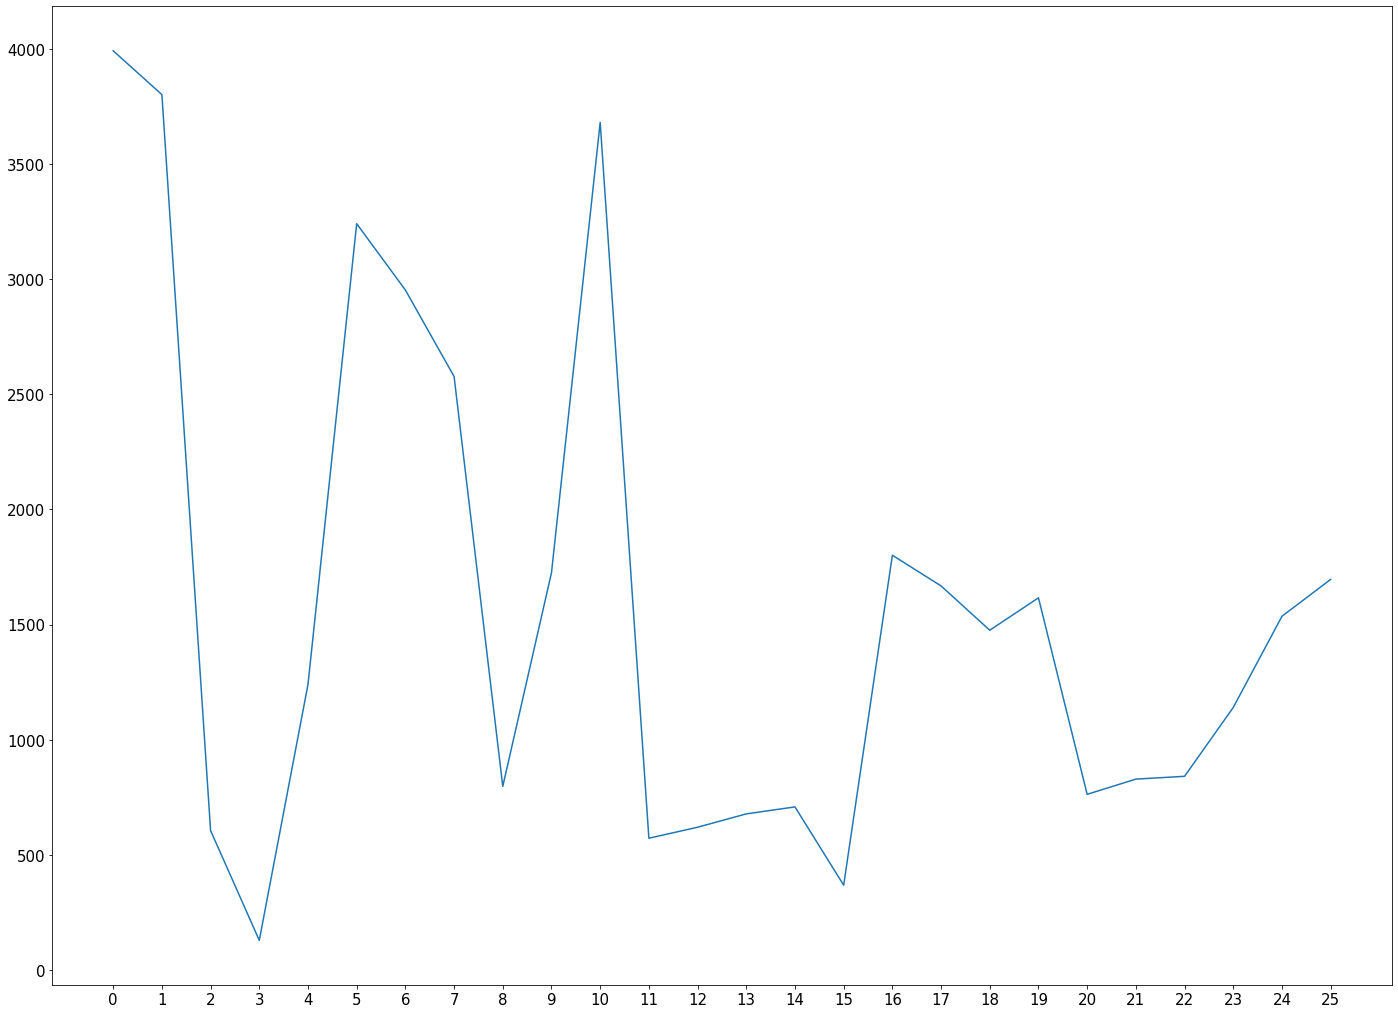

In [673]:
scores = X_best.scores_
fig, ax = plt.subplots()
ax = plt.rcParams["figure.figsize"] = [24,18]
ax = plt.plot(scores)
plt.xticks(np.arange(26),np.arange(26), size = 15 )
plt.yticks(size = 15)

In [674]:
data_standarizada.columns[[0,1,5,7,10,16,19,24,25]]

Index(['second_sp', 'second_dp', 'p1_d', 'p3_d', 'min_d', '#sp', 'first_dp',
       'p2_ib', 'p3_ib'],
      dtype='object')

In [675]:
y = data_I['Type']
X = data_I[data_numeric.columns]

In [676]:
clf = ExtraTreesClassifier(n_estimators = 26)
clf = clf.fit(X,y)
model = SelectFromModel(clf, prefit=True)

In [677]:
X[X.columns[model.get_support(indices = True)]].columns

Index(['second_sp', 'second_dp', 'p1_d', 'p2_d', 'min_d', '#sp', '#dp',
       'first_sp', 'first_dp'],
      dtype='object')

In [678]:
y = data_p['Type_mine']
X = data_standarizada

In [679]:
dis_l = LinearDiscriminantAnalysis(n_components=None)

In [680]:
X_disl = dis_l.fit(X, y)
X_disl

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [681]:
model = SelectFromModel(X_disl, prefit=True)
X[X.columns[model.get_support(indices = True)]].columns

Index(['second_sp', 'second_dp', '#sp', '#dp', 'first_sp', 'first_dp', 'p1_ip',
       'p2_ip', 'p3_ib'],
      dtype='object')

In [682]:
feature_seleccionadas = ['first_sp','first_dp','second_sp', 'second_dp','p1_d', 'p3_d','min_d','#sp','#dp','p1_ip',
       'p2_ip', 'p3_ib']

In [683]:
feature_seleccionadas = data_standarizada[feature_seleccionadas]

In [684]:
X = feature_seleccionadas
y = data_I['Type']

### Holdout

In [685]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size=0.3, random_state = 0)

# KNN

In [686]:
k_vec = np.arange(1,40,2)
vec_train = []
vec_test =[]

for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    vec_train.append(metrics.accuracy_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    vec_test.append(metrics.accuracy_score(y_test, y_pred))
v = pd.DataFrame()
v['K'] = k_vec
v['vec_train'] = vec_train
v['vec_test'] = vec_test
display(v)

,K,vec_train,vec_test
0,1,1.000000,0.999296
1,3,0.998793,0.999296
2,5,0.998189,0.999296
3,7,0.996982,0.997183
4,9,0.995774,0.996479
5,11,0.994567,0.995775
6,13,0.994265,0.995070
7,15,0.994265,0.995070
8,17,0.995774,0.995070
9,19,0.995774,0.994366


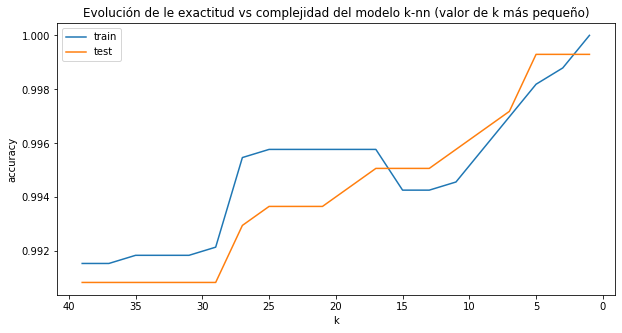

In [687]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(k_vec, vec_train)
plt.plot(k_vec, vec_test)
ax.set_xlim(ax.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Evolución de le exactitud vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

In [688]:
k_best = 9

In [689]:
knn = KNeighborsClassifier(n_neighbors=k_best)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [690]:
y_pred = knn.predict(X_test)

### Métricas y matriz de confusión

In [691]:
data_I['Type'].values

array(['not_mine', 'mine', 'mine', ..., 'mine', 'not_mine', 'not_mine'],
      dtype=object)

In [692]:
y_test.shape, y_pred.shape

((1420,), (1420,))

([<matplotlib.axis.YTick at 0x16b8f9470f0>,
 <a list of 2 Text yticklabel objects>)

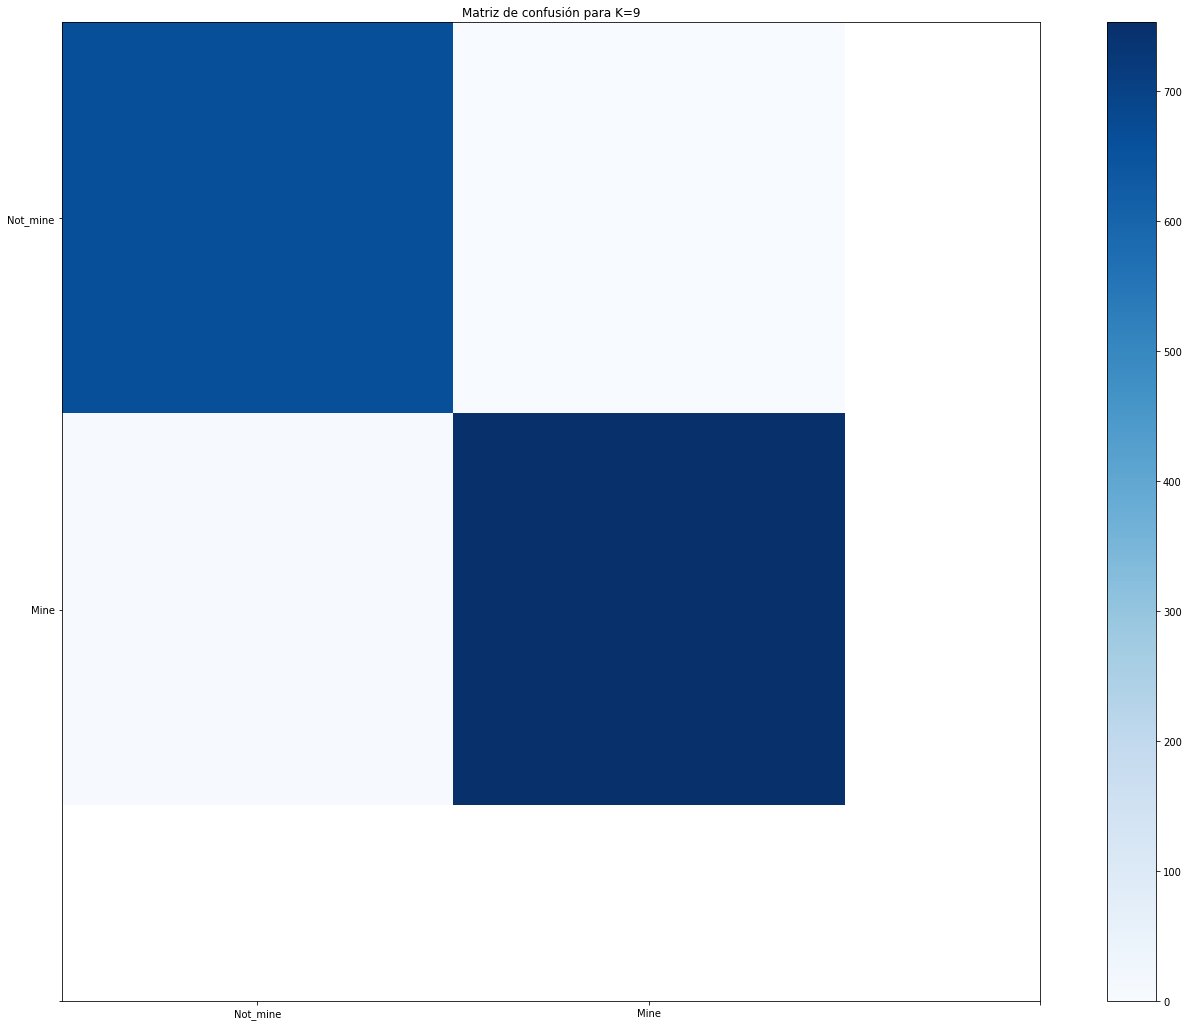

In [693]:
churm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(churm, cmap=plt.cm.Blues)
plt.title(f"Matriz de confusión para K={k_best}")
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [694]:
churm

array([[662,   0],
       [  5, 753]], dtype=int64)

In [695]:
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa: ", metrics.accuracy_score(y_test, y_pred))

Exactitud:  0.9964788732394366
Kappa:  0.9964788732394366


In [696]:
print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=['mine'], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=['mine'], average='macro'))

VN = np.sum(churm[1:3,1:3])
FP = np.sum(churm[0,1:3])
specificity = VN/(VN+FP)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=['mine'], average='macro'))


Precisión     :  0.992503748125937
Recall        :  1.0
Especificidad :  1.0
F1-score      :  0.9962377727614748


In [697]:
print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=['not_mine'], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=['not_mine'], average='macro'))

VN = np.sum(churm[1:3,1:3])
FP = np.sum(churm[0,1:3])
specificity = VN/(VN+FP)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=['not_mine'], average='macro'))

Precisión     :  1.0
Recall        :  0.9934036939313984
Especificidad :  1.0
F1-score      :  0.9966909331568498


In [698]:
data_N = pd.read_csv('./data_no_identificada.csv')
data_N.head(1)

,index,Name,Netflows,First_Protocol,Second_Protocol,Third_Protocol,p1_d,p2_d,p3_d,duration,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,8992,18-csves/1435.csv,5,ICMP,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,1.0,1.0,1.0,40.0,286.0,286.0,mine,Unclassified


In [699]:
from sklearn.pipeline import Pipeline

In [700]:
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(missing_values = np.nan, strategy = "median")),
                            ('scaler', StandardScaler())
                        ]
                      )

In [701]:
data_numeric = data_I.select_dtypes(include = ['float64', 'int64']).columns.to_list()

In [702]:
preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, data_numeric),
                    ],
                    remainder='passthrough'
                )

In [704]:
data_numeric = data_N[data_numeric]

In [705]:
va_N = preprocessor.fit_transform(data_numeric)
temp = pd.DataFrame(va_N, columns = data_numeric.columns)

In [720]:
temp.shape

(39554, 26)

In [750]:
temp2 = temp.loc[0:3312]

In [751]:
temp2.shape

(3313, 26)

In [752]:

y_pred = knn.predict(temp2)

ValueError: query data dimension must match training data dimension

### Cross_Val_Score

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9)
exactitud = cross_val_score(knn, X_cod, y_cod, cv = 10, scoring='accuracy')
exactitud

In [ ]:
print("Exactitudes: %0.2f (+/- %0.2f)" % (exactitud.mean(), exactitud.std() * 2), exactitud.mean(), exactitud.std())

In [ ]:
data_no_ident = pd.read_csv('Data_No_Identificada_Tratada.csv', sep=',')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
            ('numeric', numeric_transformer, data_num_c)],remainder='passthrough'
                )

In [ ]:
data_scaler2 = data_no_ident[data_num_c]

In [ ]:
preprocessor.fit_transform(data_scaler2)
datos_transf2 = preprocessor.transform(data_scaler2)
datos_transf2 = pd.DataFrame(datos_transf2, columns=data_scaler2.columns)
datos_transf2 = pd.concat([datos_transf2, data_no_ident[data_obje_c]],axis=1)

In [ ]:
X2 = datos_transf2[data_num_c]
y2 = datos_transf2['Type']

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,stratify=y2)

In [ ]:
k_vec = np.arange(1,40,2)
k_vec

In [ ]:
temp = y_test2[0:1184]

In [ ]:
vec_train_2 = []
vec_test_2 =[]

for k in  k_vec:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_train)
    vec_train_2.append(metrics.accuracy_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    vec_test_2.append(metrics.accuracy_score(temp, y_pred))
v = pd.DataFrame()
v['k'] = k_vec
v['vec_train'] = vec_train_2
v['vec_test'] = vec_test_2
display(v)

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(k_vec, vec_train_2)
plt.plot(k_vec, vec_test_2)
ax.set_xlim(ax.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Evolución de le exactitud vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
acc_test_vec=[]
for indices_train, indices_test in kf.split(X_cod, y_cod):
    knn.fit(X_cod[indices_train], y_cod[indices_train])
    y_pred = knn.predict(X_cod[indices_test])
    acc_test_vec.append(metrics.accuracy_score(y_cod[indices_test], y_pred))  
acc_test_vec

https://www.analyticslane.com/2018/07/02/gridsearchcv/#:~:text=GridSearchCV%20es%20una%20clase%20disponible,los%20par%C3%A1metros%20de%20un%20modelo.&text=En%20caso%20de%20que%20se,aleatorios%20existe%20el%20m%C3%A9todo%20RandomizedSearchCV.